In [1]:
import scipy.stats as stats
import statsmodels.stats as sts
from statsmodels.stats import power
import numpy as np
import warnings

warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
#from numpy import random
import pandas as pd
import scipy

In [3]:
data = pd.read_excel('AB_Test_Results.xlsx')
data.head(10)

,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.0
1,2423,control,0.0
2,9411,control,0.0
3,7311,control,0.0
4,6174,variant,0.0
5,2380,variant,0.0
6,2849,control,0.0
7,9168,control,0.0
8,6205,variant,0.0
9,7548,control,0.0


Проверим, есть ли в нашем датасете пустые строки и типы данных. 

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   USER_ID       10000 non-null  int64  
 1   VARIANT_NAME  10000 non-null  object 
 2   REVENUE       10000 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 234.5+ KB


Пустых строк нет, в столбце REVENUE стоит тип данных float, что позволяет нам дальше рпботатть с нашими данными.


In [5]:
data.shape

(10000, 3)

In [6]:
data.describe()

,USER_ID,REVENUE
count,10000.000000,10000.000000
mean,4981.080200,0.099447
std,2890.590115,2.318529
min,2.000000,0.000000
25%,2468.750000,0.000000
50%,4962.000000,0.000000
75%,7511.500000,0.000000
max,10000.000000,196.010000


Исходя из описания наших данных, можем сделать вывод, что все ненулевые значения у нас находятся в 4 квантиле.

In [7]:
data.isna().sum()

USER_ID         0
VARIANT_NAME    0
REVENUE         0
dtype: int64

In [8]:
data.VARIANT_NAME.value_counts()

variant    5016
control    4984
Name: VARIANT_NAME, dtype: int64

Проверили как у нас распределились пользователи по группвм, и видим, что сплитование в целом равное.


In [33]:
df = data[data['REVENUE']>0]
df

,USER_ID,VARIANT_NAME,REVENUE
13,2529,variant,2.15
49,6429,control,3.25
139,3331,variant,4.27
149,8110,variant,1.75
152,8607,control,2.99
...,...,...,...
9651,9928,variant,1.25
9711,6468,control,2.93
9724,5205,control,14.17
9725,702,variant,2.92


In [34]:
df[df['VARIANT_NAME']=='control'].describe()

,USER_ID,REVENUE
count,80.000000,80.000000
mean,4461.950000,8.037500
std,2826.386242,22.498124
min,124.000000,0.020000
25%,2037.500000,1.515000
50%,4327.000000,2.960000
75%,6636.750000,6.657500
max,9766.000000,196.010000


In [35]:
df[df['VARIANT_NAME'] == 'variant'].describe()

,USER_ID,REVENUE
count,72.000000,72.000000
mean,5306.958333,4.881528
std,3116.544256,9.913973
min,56.000000,0.020000
25%,2707.500000,1.245000
50%,5721.000000,2.170000
75%,7963.750000,3.972500
max,9996.000000,58.630000


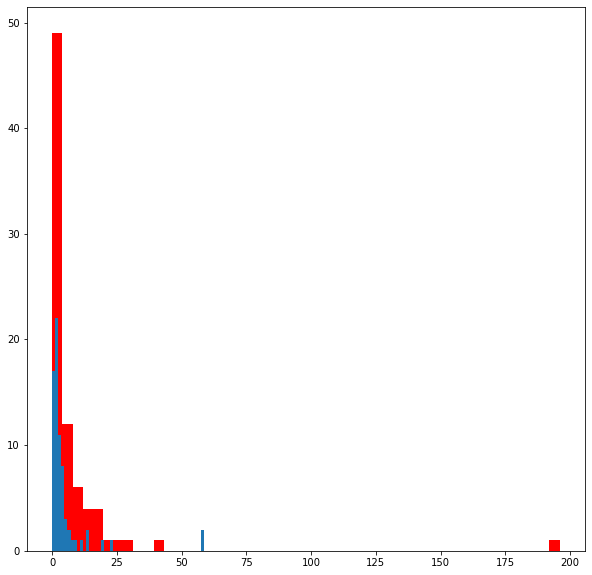

In [36]:
plt.figure(figsize=(10,10))
control_revenue = df['REVENUE'][df['VARIANT_NAME']=='control']
test_revenue = df['REVENUE'][df['VARIANT_NAME']== 'variant']

plt.hist(control_revenue, color='r', bins = 50)
plt.hist(test_revenue, bins=50)

plt.show()

По графику видим, что у нас ненормальное распределение. Проверим это еще и тестом Манна-Уитни.

In [37]:
mw_stats = stats.mannwhitneyu(x=df[df['VARIANT_NAME'] == 'control']['REVENUE'].values,
                             y = df[df['VARIANT_NAME'] == 'variant']['REVENUE'].values)
mw_stats

MannwhitneyuResult(statistic=3356.0, pvalue=0.07924299810603061)

In [39]:
variants = df.\
    groupby('USER_ID', as_index=False).\
    agg({'VARIANT_NAME': pd.Series.nunique})
variants.head(10)

,USER_ID,VARIANT_NAME
0,56,1
1,124,1
2,169,1
3,282,1
4,403,1
5,443,1
6,487,1
7,552,1
8,617,1
9,618,1


In [40]:
both_variant = variants.query('VARIANT_NAME > 1')

In [41]:
new_data = df[~df.USER_ID.isin(both_variant.USER_ID)].sort_values('USER_ID')
new_data.head(10)

,USER_ID,VARIANT_NAME,REVENUE
7949,56,variant,2.99
6378,124,control,1.25
4454,169,control,4.33
5530,282,control,18.56
8374,403,variant,1.99
9168,443,variant,3.75
6081,487,control,4.33
6167,552,control,2.99
1901,617,variant,3.98
3933,618,control,2.19


In [42]:
new_data.shape

(150, 3)

In [43]:
control = new_data.query('VARIANT_NAME == "control"')
test = new_data.query('VARIANT_NAME == "variant"')

In [44]:
len(control)

79

In [45]:
len(test)

71

In [46]:
alpha = 0.05

st = stats.shapiro(data.REVENUE)
print('Distribution is {}normal\n'.format( {True: 'not ',
                                           False:''}[st[1]<alpha]));

Distribution is not normal



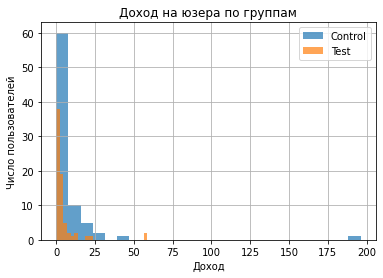

In [47]:
control.REVENUE.hist(bins = 25, alpha = 0.7, label= 'Control')
test.REVENUE.hist(bins=25,alpha=0.7,label= 'Test')
plt.title('Доход на юзера по группам')
plt.xlabel('Доход')
plt.ylabel('Число пользователей')
plt.legend();

In [48]:
mw_stats = stats.mannwhitneyu(x= control.REVENUE.values,
                       y = test.REVENUE.values)
mw_stats

MannwhitneyuResult(statistic=3267.5, pvalue=0.08163080826966929)

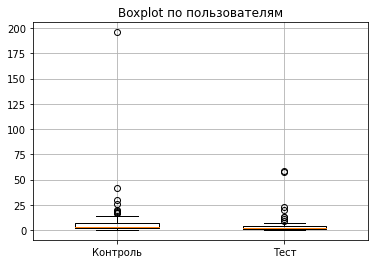

In [49]:
plt.boxplot([control.REVENUE, test.REVENUE],
           labels = ['Контроль', 'Тест'],
           widths=0.5)
plt.title('Boxplot по пользователям', loc= 'center')
plt.grid(axis = 'both')

In [50]:
stats.ttest_ind(control.REVENUE.values, test.REVENUE.values, equal_var = False)


Ttest_indResult(statistic=1.1363816685643437, pvalue=0.258274089476926)

In [51]:
C_mean = control.REVENUE.values.mean()
T_mean = test.REVENUE.values.mean()

C_std = control.REVENUE.values.std()
T_std = test.REVENUE.values.std()

In [52]:
print(len(control.REVENUE.values), len(test.REVENUE.values))

79 71


In [53]:
n = len(control.REVENUE.values)

In [54]:
S_pooled = np.sqrt((C_std**2+T_std**2)/2)

In [55]:
ef = float((C_mean-T_mean)/S_pooled)

In [56]:
alpha = 0.05

analysis = sts.power.TTestIndPower()
result = analysis.solve_power(ef, power= None,
                             nobs1= n, ratio= 1.0, alpha= alpha)
result

0.20909732505680242

## Выводы:

Мощность теста недостаточна для заключения выводов.

Статистической значимости не наблюдаем.

Необходимо отправить тест на перезапуск с болшими выборками, чтобы повысить мощность теста.

В целом выборка не совсем корректна, так как юзеры в выборке попали в обе группы.